In [ ]:
import os
import json
import typing
from typing import List, Dict
import datetime
import matplotlib.pyplot as plt
import itertools
from decimal import Decimal

from sklearn.model_selection import train_test_split
import numpy as np
import cv2

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import Dataset, DataLoader

In [ ]:
!nvidia-smi  # view GPU
from google.colab import drive
drive.mount('/content/drive')
ROOT_DIR = '/content/drive/My Drive/subaru'
os.chdir(ROOT_DIR)
os.listdir()  # !ls

# Global Constants

In [ ]:
# json中所需数据的key
SRC_JSON_KEY = ['OwnSpeed',  'StrDeg',  'inf_DP', 'Distance_ref',  'TgtXPos_LeftUp',  'TgtYPos_LeftUp',  'TgtWidth',  'TgtHeight']
TGT_JSON_KEY = 'TgtSpeed_ref'

# 文件路径
TRAIN_PATH: List[str] = [r"{}/data/train_annotations/{}".format(ROOT_DIR, p) for p in sorted(os.listdir(r"{}/data/train_annotations".format(ROOT_DIR)))]

TEST_NO: List[str] = [p for p in sorted(os.listdir(r"{}/data/test_videos".format(ROOT_DIR)))]
RAW_TEST_ANNO_PATH: List[str] = [r"{}/data/test_annotations/{}.json".format(ROOT_DIR, p) for p in TEST_NO]
RAW_TEST_IMAGE_PATH: List[str] = [r"{}/data/test_videos/{}/disparity".format(ROOT_DIR, p) for p in TEST_NO]
RAW_TEST_VIDEO_PATH: List[str] = [r"{}/data/test_videos/{}/Right.mp4".format(ROOT_DIR, p) for p in TEST_NO]

TEST_PATH: List[str]= [r"{}/data/final_test_annotations/{:0>3d}.json".format(ROOT_DIR, p) for p in TEST_NO]

# Get data for model

##  Calculate the distance from the vehicle in front and track it.

In [ ]:
start = datetime.datetime.now()

right_image_height = 420
disparity_image_width = 256

for i, p in enumerate(RAW_TEST_ANNO_PATH):
    print("i:", i)
    with open(p) as f:
        scene = json.load(f)

    first_frame = scene['sequence'][0]
    x, y = int(first_frame['TgtXPos_LeftUp']), int(first_frame['TgtYPos_LeftUp'])
    w, h = int(first_frame['TgtWidth']), int(first_frame['TgtHeight'])

    tracker = cv2.TrackerKCF_create()
    video = cv2.VideoCapture(RAW_TEST_VIDEO_PATH[i])

    is_ok, frame = video.read()
    bbox = (x, y, w, h)
    tracker.init(frame, bbox)
    
    j = 1
    while is_ok:
        is_ok, frame = video.read()
        _, bbox = tracker.update(frame)
        if is_ok:
            x, y, w, h = [float(Decimal(item).quantize(Decimal("0"), rounding = "ROUND_HALF_UP")) for item in bbox]  
            scene['sequence'][j]['TgtXPos_LeftUp'] = x
            scene['sequence'][j]['TgtYPos_LeftUp'] = y
            scene['sequence'][j]['TgtWidth'] = w
            scene['sequence'][j]['TgtHeight'] = h
            j += 1



    for k, image_path in enumerate(sorted(os.listdir(RAW_TEST_IMAGE_PATH[i]))):
        image_path = r"{}/{}".format(RAW_TEST_IMAGE_PATH[i], image_path)
        with open(image_path, 'rb') as f:
            disparity_image = f.read()
        
        # 全画素に対して距離を算出
        x = scene['sequence'][k]['TgtXPos_LeftUp']
        y = scene['sequence'][k]['TgtYPos_LeftUp']
        w = scene['sequence'][k]['TgtWidth']
        h = scene['sequence'][k]['TgtHeight']
        inf_DP = scene['sequence'][k]['inf_DP']
        

        distance_list = []
        for right_i in range(int(x + w / 10 * 3), int(x + w / 10 * 7)):
            for right_j in range(int(y + h / 10 * 3), int(y + h / 10 * 7)):
                # 右画像座標位置に対応する視差画像座標を求める
                # 視差画像と右画像は原点が左下と左上で違うため上下反転
                disparity_j = int((right_image_height - right_j - 1) / 4) # 縦座標
                disparity_i = int(right_i / 4) # 横座標

                # 視差を読み込む
                # 整数視差読み込み
                if ((disparity_j * disparity_image_width + disparity_i) * 2) < len(disparity_image):
                    disparity_int = disparity_image[(disparity_j * disparity_image_width + disparity_i) * 2]
                    # 小数視差読み込み
                    disparity_float = disparity_image[(disparity_j * disparity_image_width + disparity_i) * 2 + 1] / 256
                    disparity = disparity_int + disparity_float
                else:  
                    disparity = 0


                # 視差距離へ変換
                if disparity > 0: # disparity = 0 は距離情報がない
                    distance = 560 / (disparity - inf_DP)
                    if distance > 0:
                        distance_list.append(distance)
        if len(distance_list) > 0:
            distance_ref = (sum(distance_list) / len(distance_list)) 
        elif k != 0: 
            distance_ref = scene['sequence'][k-1]['Distance_ref']
            print("k:", k)
        else:
            distance_ref = 30
            print("k=0", k)

        scene['sequence'][k]['Distance_ref'] = distance_ref

    scene = json.dumps(scene)
    
    if 0:
        with open(TEST_PATH[i], "w") as f:
            f.write(scene)
       
end = datetime.datetime.now()
print("time: {}".format(end-start))

## Json to Data Loader

In [ ]:
class MakeData(Dataset):
    def __init__(self, path: List[str], is_test: bool):
        super(MakeData, self).__init__()
        self.path = path
        self.is_test = is_test
        self.src, self.tgt_weight_jsonname = self.__json2list__()  # 自定义函数
  
    def __json2list__(self):
        """
        将json文件中的数据处理为list类型
        """
        src: List[List[List[float]]] = []
        tgt_weight_jsonname: List[List[List[float, int]]] = []
        for i, p in enumerate(self.path):
            with open(p) as f:
                data = json.load(f)
                if self.is_test:
                    weight = -1
                else:
                    weight = 3 if data['attributes']['評価値計算時の重み付加'] == '有' else 1

                json_name: str = p[-8:-5]
                src.append([])
                tgt_weight_jsonname.append([])
                for j, line in enumerate(data['sequence']):
                    tgt_weight_jsonname[i].append([line[TGT_JSON_KEY] if not self.is_test else -1, weight, json_name])
                    src[i].append([line[item] for item in SRC_JSON_KEY] )

        return src, tgt_weight_jsonname
  
    def __len__(self):
        return len(self.src)
    
    def __getitem__(self, index):
        return self.src[index], self.tgt_weight_jsonname[index]

    # def __is_scene_end__(self, index):
    #     """
    #     判断该index下的数据是否为视频最后一帧
    #     """
    #     return self.is_scene_end[index]
    
    # def __weight__(self, index):
    #     return self.weight[index]

In [ ]:
def batch_pre_processing(scenes_in_one_batch):
    """
    scenes_in_one_batch: (batch_size, 2)
                                     List[
                                            Tuple[
                                                     List[List[float]],
                                                     List[float]
                                                    ]
                                           ]
    return: 排序&padding后的数据
               记录了有效位长度的lengths
               记录了有效位分布的mask(布尔型)
               list2tensor
    """
    def __sort_scenes_in_batch(src: List[List[List[float]]], tgt: List[List[float]]):
        """
        在一个batch内的视频/scenes, 按照帧数降序排序
        排序依据为src数据，tgt数据不需排序，但需与src数据一一相对应
        """
        #对src_tgt进行排序，按照src的视频内帧数长短降序排列，返回排列后的src_tgt
        src_tgt = sorted(zip(src, tgt), key=lambda x: len(x[0]), reverse=True)  # reverse = True 降序
        
        # 拆分src, tgt
        src, tgt  = list(zip(*src_tgt))
        src: List[List[List[float]]] = list(src)
        tgt: List[List[float]] = list(tgt)

        return src, tgt

    def __get_lengths(src: List[List[List[float]]]):
        """
        src: 排序后的src
        return: src的有效帧数
        """
        src_lengths = [len(item) for item in src]
        return src_lengths
    
    def __get_padded(src, tgt):
        """
        padding
        RNN或Seq2Seq模型需按照时间顺序依次输入每一帧，scene_len不可并行处理，故将其从第二个维度调整至第一个维度
        """
        src = list(itertools.zip_longest(*src, fillvalue= [0]*8))
        tgt = list(itertools.zip_longest(*tgt, fillvalue= 0))
        src = [list(item) for item in src]
        tgt = [list(item) for item in tgt]
        return src, tgt

    def __get_mask(tgt):
        tgt_mask = []
        for i in tgt:
            temp=[]
            for j in i:
                temp.append(0) if j==0 else temp.append(1)   
            tgt_mask.append(temp)
        return tgt_mask
    
    

    src: List[List[List[float]]] = [line[0] for line in scenes_in_one_batch]
    tgt_weight_jsonname: List[List[List[float]], List[List[int]]] = [line[1] for line in scenes_in_one_batch]
    
    # 排序
    src, tgt_weight_jsonname = __sort_scenes_in_batch(src, tgt_weight_jsonname)

    # 拆分出tgt, weight, json_name
    weight = []
    json_name = []
    tgt = []
    for scene in tgt_weight_jsonname:
        weight.append(scene[0][1])  # batch内每个视频第一帧的权重
        json_name.append(scene[0][2])
        tgt_temp = []
        for  frame in scene:
            tgt_temp.append(frame[0])
        tgt.append(tgt_temp)
    
    # 取src中每个视频的长度
    src_lengths = __get_lengths(src)

    # padding
    src, tgt = __get_padded(src, tgt) 

    # mask
    tgt_mask = __get_mask(tgt)


    return torch.Tensor(src), \
              torch.Tensor(tgt),  \
              torch.LongTensor(src_lengths), \
              torch.BoolTensor(tgt_mask), \
              torch.LongTensor(weight), \
              json_name


In [ ]:
BATCH_SIZE = 64

# 数据集分割train&validation
train_path, val_path = train_test_split(TRAIN_PATH, test_size=0.25, train_size=0.75, random_state=42, shuffle=True)  
train_dataset = MakeData(train_path, is_test=False)
val_dataset = MakeData(val_path, is_test=False)

test_dataset = MakeData(TEST_PATH, is_test=True)

# batch化
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, collate_fn=batch_pre_processing, shuffle=False, drop_last=False)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, collate_fn=batch_pre_processing, shuffle=False, drop_last=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, collate_fn=batch_pre_processing, shuffle=False, drop_last=False)

# Model


## RNN Model
- 模型采用RNN：在此次任务中，输出与输入长度需保持完全一致，RNN较Seq2Seq更适用此次任务

In [ ]:
class RNNModel(nn.Module):
    def __init__(self, hidden_size, input_size=8, output_size=1, n_layers=2, hidden=None,  dropout=None):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.gru  = nn.GRU(input_size, hidden_size, n_layers, bidirectional=False)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, input, input_lengths, hidden=None):
        """
        input: (scene_len, batch_size, 7)
            scene_len: 每个视频内的帧数
            7: 主办方为每一帧提供的7个特征值
        src_lengths: 每个视频下的有效帧数
        """
        # pack打包, 只保留有效帧，GRU或LSTM可处理序列长短不一的输入
        packed_input = nn.utils.rnn.pack_padded_sequence(input, input_lengths.cpu())

        output, hidden = self.gru(packed_input, hidden)

        output, _ = nn.utils.rnn.pad_packed_sequence(output)

        # output = torch.transpose(output ,0,1)

        # hidden_cat = torch.cat([hidden[-1], hidden[-2]], dim=1)
 
        output = self.fc(output)
        output = torch.squeeze(output)
        
        return output

## Hyperparameters

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

BATCH_SIZE = 64
HIDDEN_SIZE = 1024
EPOCH = 200

model = RNNModel(HIDDEN_SIZE).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

cuda


## Loss Function

### for train
masked Mean Squared Error

In [ ]:
def mask_loss(pred, tgt, mask):
    """
    以1个batch为单位
    3个输入的维度都是[seq_len, batch_size]
    """
    loss = pow((pred-tgt), 2)
    loss = loss.masked_select(mask).mean()
    return loss

### for validation

- 各シーンに対する誤差
$$e_j = \frac{1}{n_j-19} \sum_{i=20}^{n_j}min(\left\vert \frac{p_i-t_i}{0.07t_i+3} \right\vert, 1)$$


$$
\begin{array}{lr}
        n_j:シーンjにおける総フレーム数\\
        p_i:(シーンjの)フレーム番号に対する予測値\\
        t_i:(シーンjの)フレーム番号に対する予測値
\end{array}
$$

<br/>

- 全てのシーンに対する誤差(重み付き平均)
$$error = \frac{\sum_{j=1}^{s}w_je_j}{\sum_{j=1}^{s}w_j}$$


$$
\begin{array}{lr}
            w_j = \left\{
                                \begin{array}{lr}
                                    3\quad ”評価値計算時の重み付加” = ”有”\\
                                    1\quad 上記以外\\
                                \end{array}
                    \right.\\
        s: 総シーン数
\end{array}
$$

In [ ]:
def val_loss(pred, tgt, mask, weight):
    """
    前19帧排除
    mask
    min(loss, 1)
    加权平均
    """
    pred = pred[19:]
    tgt = tgt[19:]
    mask = mask[19:]

    seq_len = tgt.size()[0]
    batch_size = tgt.size()[1]

    loss = torch.abs((pred - tgt)/(0.07*tgt + 3))

    full_one = torch.full([seq_len, batch_size], 1).to(DEVICE)
    loss = loss.min(full_one)


    # 分别求每个seq内的平均值
    loss = loss.masked_select(mask).mean(dim=0)

    # 加权求和
    loss = (loss * weight).sum()
    
    # 存储该batch内weight和，方便最终计算所有batch的加权平均 
    weight = weight.sum()

    return loss, weight

# Train

In [ ]:
start = datetime.datetime.now()

for epoch in range(EPOCH):

    model.train()
    epoch_loss = 0

    # batch内训练
    for i, data in enumerate(train_loader):
        src, tgt, src_lengths, tgt_mask, weight, _ = data
        src, tgt, src_lengths, tgt_mask, weight = src.to(DEVICE), tgt.to(DEVICE), src_lengths.to(DEVICE), tgt_mask.to(DEVICE), weight.to(DEVICE)
        
        optimizer.zero_grad()  # 梯度归零

        pred = model(src, src_lengths)
        batch_loss = mask_loss(pred, tgt, tgt_mask)

        batch_loss.backward()   
        optimizer.step()  # 梯度更新

        epoch_loss += batch_loss.item()
        # if i%500 == 0:
        #     print("epoch {:0>2} batch {:0>4}  {}".format(epoch+1, i+1, loss.item()))

        
    epoch_loss = epoch_loss / (i+1)
    print("epoch {:0>2} train_loss  {}".format(epoch+1, epoch_loss))

    # validate
    model.eval()
    val_epoch_loss = 0
    val_epoch_weight = 0
    for j, val_data in enumerate(val_loader):
        val_src, val_tgt, val_src_lengths, val_tgt_mask, val_weight, _ = val_data
        val_src, val_tgt, val_src_lengths, val_tgt_mask, val_weight = val_src.to(DEVICE), val_tgt.to(DEVICE), val_src_lengths.to(DEVICE), val_tgt_mask.to(DEVICE), val_weight.to(DEVICE)

        val_pred = model(val_src, val_src_lengths)
        val_batch_loss, val_batch_weight = val_loss(val_pred, val_tgt, val_tgt_mask, val_weight)

        val_epoch_loss += val_batch_loss.item()
        val_epoch_weight += val_batch_weight.item()
        
    val_epoch_loss = val_epoch_loss / val_epoch_weight
    print("epoch {:0>2} val_loss: {}".format(epoch+1, val_epoch_loss))
    print()

    # save checkpoint
    torch.save({ "epoch": epoch+1,
                        "state_dict": model.state_dict(),
                        "epoch_loss": epoch_loss,
                        "val_epoch_loss": val_epoch_loss,
                        "optimizer": optimizer.state_dict() },
                
                    "{}/ckpt/ckpt{:0>2d}.tar".format(ROOT_DIR, epoch+1) 
                    )


end = datetime.datetime.now()
print("time: {}".format(end-start))

epoch 01 train_loss  2867.5318739149307
epoch 01 val_loss: 0.970859042080966

epoch 02 train_loss  1956.9144694010417
epoch 02 val_loss: 0.924691855690696

epoch 03 train_loss  1431.1302625868057
epoch 03 val_loss: 0.9063025179776278

epoch 04 train_loss  1082.247551812066
epoch 04 val_loss: 0.9239561878551137

epoch 05 train_loss  867.6437784830729
epoch 05 val_loss: 0.9261195789683949

epoch 06 train_loss  650.3599683973524
epoch 06 val_loss: 0.8931781560724432

epoch 07 train_loss  488.35402425130206
epoch 07 val_loss: 0.8910694746537642

epoch 08 train_loss  347.6688113742405
epoch 08 val_loss: 0.8754231123490767

epoch 09 train_loss  255.06676059299045
epoch 09 val_loss: 0.7593923117897727

epoch 10 train_loss  183.77082994249133
epoch 10 val_loss: 0.6877234164151278

epoch 11 train_loss  141.62978871663412
epoch 11 val_loss: 0.6861620538884943

epoch 12 train_loss  104.95794932047527
epoch 12 val_loss: 0.6080736194957387

epoch 13 train_loss  88.838136461046
epoch 13 val_loss: 0.

0.2694357161088423
[0.970859042080966, 0.924691855690696, 0.9063025179776278, 0.9239561878551137, 0.9261195789683949, 0.8931781560724432, 0.8910694746537642, 0.8754231123490767, 0.7593923117897727, 0.6877234164151278, 0.6861620538884943, 0.6080736194957387, 0.6620827276056463, 0.5582544777610086, 0.5604564736106179, 0.5152363863858309, 0.5204489968039773, 0.5278897788307884, 0.5203841469504616, 0.5170894830877131, 0.5013311628861861, 0.47342168634588067, 0.44521893587979405, 0.42833555741743606, 0.40878750887784093, 0.4401416570490057, 0.41549319180575284, 0.4447735595703125, 0.40404957164417615, 0.49101966164328836, 0.40196922995827417, 0.4174102783203125, 0.3963284440474077, 0.47051010131835935, 0.4330775451660156, 0.38869258533824574, 0.41976586081764916, 0.3988165421919389, 0.4272067122025923, 0.37480864091352983, 0.40444890802556815, 0.4839523870294744, 0.48809011285955256, 0.39842845569957386, 0.37781268033114346, 0.3561478285356001, 0.38338648015802557, 0.34651996959339487, 0.38

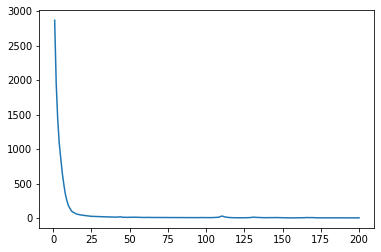

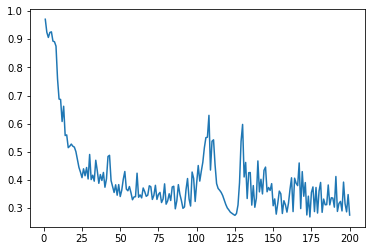

In [ ]:
train_loss_list = []
val_loss_list = []
for i in range(EPOCH):
    load_ckpt_path = "{}/ckpt/ckpt{:0>2d}.tar".format(ROOT_DIR, i+1) 
    ckpt = torch.load(load_ckpt_path)
    train_loss_list += [ckpt['epoch_loss']]
    val_loss_list += [ckpt['val_epoch_loss']]


print(min(val_loss_list))
print(val_loss_list)
# plt.figure(figsize=(50, 20))
plt.plot(range(1, EPOCH+1), train_loss_list)
plt.show()
plt.plot(range(1, EPOCH+1), val_loss_list)
plt.show()

In [ ]:
# val中loss最小的epoch
print(val_loss_list.index(min(val_loss_list)))

173


# Generation

In [ ]:
# 加载checkpoint
load_ckpt_path = ROOT_DIR + "/ckpt/ckpt174.tar"
ckpt = torch.load(load_ckpt_path, map_location=DEVICE)
model.load_state_dict(ckpt['state_dict'])
optimizer.load_state_dict(ckpt['optimizer'])
print("epoch:{}\ntrain_loss:{}\nval_loss:{}".format(ckpt['epoch'], ckpt['epoch_loss'], ckpt['val_epoch_loss']))

epoch:174
train_loss:6.2126779026455345
val_loss:0.2694357161088423


In [ ]:
pred_dict = {}
model.eval()
for i, data in enumerate(test_loader):
    src, tgt, src_lengths, tgt_mask, weight, json_name = data
    src, src_lengths = src.to(DEVICE), src_lengths.to(DEVICE)

    pred = model(src, src_lengths)  # [seq_len, batch_size]

    pred = pred.permute(1, 0)  # [batch_size, seq_len]

    pred = pred.tolist()
    src_lengths = src_lengths.tolist()
    

    for i, scene in enumerate(pred):  # pred: [batch_size, seq_len]
        scene = scene[:src_lengths[i]]  # 舍去padding的部分
        pred_dict[json_name[i]] = scene


pred_dict_sorted = {}  # 按照视频名排序后的pred_dict 
for key in sorted(pred_dict):
    pred_dict_sorted[key] = pred_dict[key]

In [ ]:
# 写入json文件
json_str = json.dumps(pred_dict_sorted)
with open (ROOT_DIR + "/pred.json", "w") as f:
    f.write(json_str)